### Import Modules

In [2]:
import numpy
from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8

### Functions

In [3]:
def readpqr(filename, N):

    '''
    Reads a pqr file and returns the atom names, coordinates, and charges.    
    '''
    pqr_file = open(filename,'r')
    
    position = numpy.zeros((N,3))
    q = numpy.zeros(N)
    amino_acid_name = numpy.array(q, dtype=numpy.string_)
    atom_name = numpy.array(q, dtype=numpy.string_)
    chain = numpy.array(q, dtype=numpy.string_)
    amino_acid_number = numpy.zeros(N, dtype=int)
    
    counter = 0
    for i, line in enumerate(pqr_file):
        line_split = line.split()
        if line_split[0] == 'ATOM':
            position[counter,0] = float(line_split[6])
            position[counter,1] = float(line_split[7])
            position[counter,2] = float(line_split[8])
            q[counter] = float(line_split[9])
            amino_acid_name[counter] = line_split[3]
            amino_acid_number[counter] = int(line_split[5])
            atom_name[counter] = line_split[2]
            chain[counter] = line_split[4]
            counter += 1
        
    return position, q, amino_acid_name, amino_acid_number, atom_name,chain

def compute_force(dphi, q):

    '''
    Computes the electrostatic force on each atom due to the repulsion of the other atoms.
    '''
    
    force = -numpy.transpose(numpy.transpose(dphi)*q)
    force_magnitude = numpy.sqrt(numpy.sum(force**2, axis=1))
    
    total_force = numpy.sum(force, axis=0)
    total_force_magnitude = numpy.sqrt(numpy.sum(total_force**2))

    C0 = 69.467*4*numpy.pi*332.0636817823836 #convertion to pN
    return C0*force, C0*force_magnitude, C0*total_force, C0*total_force_magnitude

def get_f_porcent_planes(x_min,x_max, h,  fqf_386, types, position, amino_acid_name, case):
    
    '''
    Find the porcentage of force in each plane for each aminoacid
    '''

    planes = numpy.arange(x_min,x_max,h) #Planes between +-h angstrom
    j = 0
    near_plane_chain = dict() 
    f_porcent_chain = dict()
    f_porcent_chain_mag = dict()
    #Set forces dictionary for each chain
    for chain in types:
        chain_name = chain.decode('utf-8')
        f_porcent_chain_mag[chain_name] = numpy.zeros(planes.shape)
        f_porcent_chain[chain_name] = numpy.zeros([int(planes.shape[0]),3])

    #Calculate forces between planes and chains
    for plane in planes:
        near_plane_abs = numpy.where(abs(position[:,0]-plane)<h/2)[0] #Plane between +-5 angstrom
        if case == 'sphere':
            f_tot_mag_386 = -2.1197685475579964
        elif case == 'cone':
            f_tot_mag_386 = -2.218853305353352123
        elif case == 'cone_40_mM':
            f_tot_mag_386 = -3.594757604969431419
        elif case == 'cone_20_mM':
            f_tot_mag_386 = -3.661415682242961545
        for chain in types:
            chain_name = chain.decode('utf-8')
            near_plane_chain[chain_name] = numpy.where(amino_acid_name[near_plane_abs] == chain)[0] #Selecting atoms of the chain 
            f_porcent_chain[chain_name][j] = numpy.sum(fqf_386[near_plane_abs[near_plane_chain[chain_name]]],axis=0)
            f_porcent_chain_mag[chain_name][j] = 100*(f_porcent_chain[chain_name][j][0])/(f_tot_mag_386)
        j += 1
    return planes, f_porcent_chain, f_porcent_chain_mag

def get_atoms_aminoacid_planes(x_min,x_max, h, types, position, amino_acid_name):

    '''
    Find the atoms of each aminoacid in each plane
    '''
    
    planes = numpy.arange(x_min,x_max,h) #Planes between +-h angstrom
    j = 0
    n_atoms = dict()
    #Set atoms dictionary for each chain
    for chain in types:
        chain_name = chain.decode('utf-8')
        n_atoms[chain_name] = numpy.zeros(planes.shape)

    #Calculate atoms between planes and chains
    for plane in planes:
        near_plane_abs = numpy.where(abs(position[:,0]-plane)<h/2)[0] #Plane between +-5 angstrom
        for chain in types:
            chain_name = chain.decode('utf-8')
            n_atoms[chain_name][j] = len(numpy.where(chain == amino_acid_name[near_plane_abs])[0])
        j += 1
    return planes, n_atoms

def get_qnet_planes(x_min,x_max, h,  q, types, position, amino_acid_name):

    '''
    Find the net charge of each aminoacid in each plane
    '''
    
    planes = numpy.arange(x_min,x_max,h) #Planes between +-h angstrom
    j = 0
    near_plane_chain = dict() 
    qnet_chain = dict()
    #Set charge dictionary for each chain
    for chain in types:
        chain_name = chain.decode('utf-8')
        qnet_chain[chain_name] = numpy.zeros(planes.shape)

    #Calculate charge between planes and chains
    for plane in planes:
        near_plane_abs = numpy.where(abs(position[:,0]-plane)<h/2)[0] #Plane between +-5 angstrom
        for chain in types:
            chain_name = chain.decode('utf-8')
            near_plane_chain[chain_name] = numpy.where(amino_acid_name[near_plane_abs] == chain)[0] #Selecting atoms of the chain 
            qnet_chain[chain_name][j] = numpy.sum(q[near_plane_abs[near_plane_chain[chain_name]]])
        j += 1
    return planes, qnet_chain

def select_case(case):
    if case == 'sphere':
        f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2) #Sphere
        top_aa = ['GLU','LYS','ASP','SER','THR']
        top_aa_color = ['tab:green','tab:blue','tab:orange','tab:pink','tab:brown']
    elif case == 'cone':
        f_tot_mag_386 = numpy.sqrt((-2.218853305353352123)**2+(2.968578948845190801e-01)**2+(-3.644038752826838506e-02)**2) #Cone
        top_aa = ['GLU','ASP','LYS','THR','SER']
        top_aa_color = ['tab:green','tab:orange','tab:blue','tab:brown','tab:pink']
    elif case == 'cone_40_mM':
        f_tot_mag_386 = numpy.sqrt((-3.594757604969431419)**2+(8.692406834832719364e-02)**2+(-3.006900128187715501e-02)**2) #Cone 40 mM
        top_aa = ['LYS','GLU','ASP','ARG','THR']
        top_aa_color = ['tab:blue','tab:green','tab:orange','tab:red','tab:brown']
    elif case == 'cone_20_mM':
        f_tot_mag_386 = numpy.sqrt((-3.661415682242961545)**2+(-2.450613861796472615e-01)**2+(1.699086204800153155e-01)**2) #Cone 20 mM
        top_aa = ['LYS','ASP','GLU','ARG','ILE']
        top_aa_color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
    
    return f_tot_mag_386, top_aa, top_aa_color

## Simulation for sphere

### Read dphir.txt files from Pygbe

In [46]:
folder='zika_afm\\tip_charge-2.5_rad150\\zatsc' #Folder containing dphir.txt files
case = 'sphere' #sphere, cone, cone_40_mM, cone_20_mM
f_tot_mag_386, top_aa, top_aa_color = select_case(case)
dphi_386c = numpy.loadtxt(folder+'386/dphir.txt')   # d=0.2nm
#dphi_390c = numpy.loadtxt(folder+'390/dphir.txt')   # d=0.6nm
#dphi_394c = numpy.loadtxt(folder+'394/dphir.txt')   # d=1.0nm
#dphi_404c = numpy.loadtxt(folder+'404/dphir.txt')   # d=2.0nm
#dphi_484c = numpy.loadtxt(folder+'484/dphir.txt')   # d=10.0nm
dphi_1384c = numpy.loadtxt(folder+'1384/dphir.txt') # d=100.0nm

# Read pqr file and calculate forces
N = len(dphi_386c)
position, q, amino_acid_name, amino_acid_number, atom_name, chain = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
delta_dphi_386_local = dphi_386c - dphi_1384c #Calculate interaction potential
fqf_386, fqf_mag_386, Fqf_386, Fqf_mag_386 = compute_force(delta_dphi_386_local, q)

# Identify aminoacids in .pqr file
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

### Figure 3a)

Plane z = 0
Atoms with force greater than 1% of the total force:  159
Atoms displaced by more than +-0.5 Angstrom:  4599
Atoms displaced by more than +-2.5 Angstrom:  22883
Total force for atoms greater than 1% of the total force:  [-0.89802116  0.04535178 -0.05836946]
Total force in slice:  [-0.27346878 -0.04588454 -0.06836799]


<Figure size 432x288 with 0 Axes>

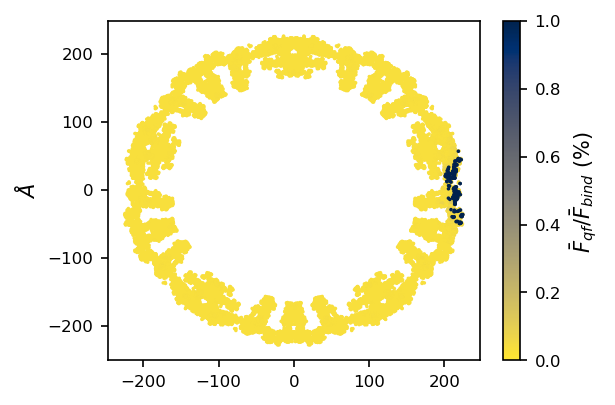

In [47]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plane = 0#-145.25
near_plane = numpy.where(abs(position[:,2]-plane)<0.5)[0] # Atoms between +-0.5 A
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A

# Plotting
x = position[near_plane,0]
y = position[near_plane,1]
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386) #Force percentage
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage
f_greater  = numpy.where(f_porcent2 > 1)[0] #Detect forces greater than 1% of the total force
fqf_plane = fqf_386[near_plane2]
fqf_plane_greater = fqf_plane[f_greater]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(x2,y2,c=f_porcent2,s=0.5, cmap='cividis_r',vmin=-0.3)
plt.scatter(x2[f_greater],y2[f_greater],c=f_porcent2[f_greater],cmap='cividis_r',s=0.5,vmin=0,vmax=1)
plt.colorbar(label=r'$ \bar{F}_{qf} /  \bar{F}_{bind} $ (%) ')
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_3a_{0}.pdf'.format(case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane z =', plane)
print('Atoms with force greater than 1% of the total force: ', len(f_greater))
print('Atoms displaced by more than +-0.5 Angstrom: ', len(near_plane))
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane2))
print('Total force for atoms greater than 1% of the total force: ', numpy.sum(fqf_plane_greater,axis=0))
print('Total force in slice: ', numpy.sum(fqf_plane,axis=0))

### Figure 3b)

Plane x = 210
Atoms between +-2.5 Angstrom: 8053


<Figure size 432x288 with 0 Axes>

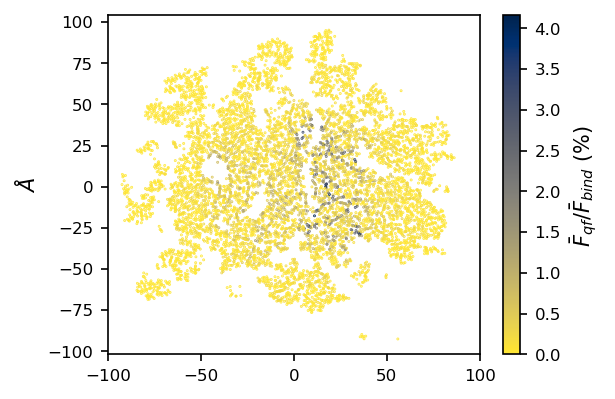

In [49]:
# Force qf plot for plane y-z (x=210) for capsid
# Select plane for the plot
plane = 210#-145.25
near_plane = numpy.where(abs(position[:,0]-plane)<2.5)[0]

# Plotting
y = position[near_plane,1]
z = position[near_plane,2]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386)
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y,z,c=f_porcent,cmap='cividis_r',vmin=0,marker='.',s=0.5)
plt.colorbar(label=r'$\bar{F}_{qf} /\bar{F}_{bind} $ (%) ')
plt.xlim([-100,100])
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_3b_{1}.pdf'.format(plane,case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane x =', plane)
print('Atoms between +-2.5 Angstrom:', len(near_plane))

### Figure 3c)

Plane x = 210
Atoms displaced by more than +-2.5 Angstrom:  8053
Atoms of GLU greater than 3.6% in slice  0
Total force for atoms of GLU greater than 3.6% of the total force:  [0. 0. 0.]
Atoms of LYS greater than 3.6% in slice  0
Total force for atoms of LYS greater than 3.6% of the total force:  [0. 0. 0.]
Atoms of ASP greater than 3.6% in slice  0
Total force for atoms of ASP greater than 3.6% of the total force:  [0. 0. 0.]
Total force in slice:  [0.37260032 0.12122362 0.02264715]


<Figure size 432x288 with 0 Axes>

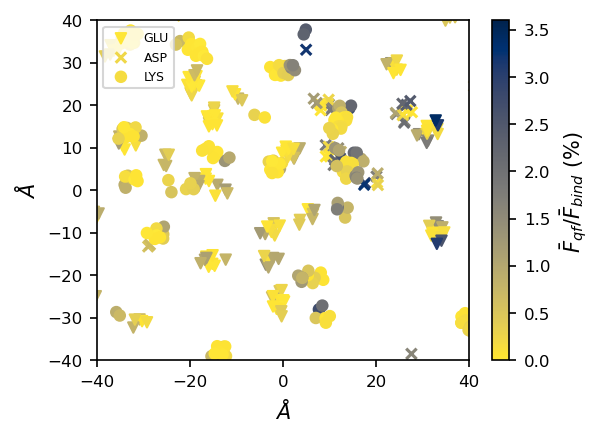

In [50]:
### Figure 3c)
# Plotting for each chain
plane = 210 #-145.25
near_plane_abs = numpy.where(abs(position[:,0]-plane)<2.5)[0] #Plane between +-1 angstrom
near_plane_GLU = numpy.where(amino_acid_name[near_plane_abs] == b'GLU')[0] #Selecting atoms of the chain GLU
near_plane_LYS = numpy.where(amino_acid_name[near_plane_abs] == b'LYS')[0] #Selecting atoms of the chain LYS
near_plane_ASP = numpy.where(amino_acid_name[near_plane_abs] == b'ASP')[0] #Selecting atoms of the chain ASP


# Plotting
y_GLU = position[near_plane_abs[near_plane_GLU],1]
z_GLU = position[near_plane_abs[near_plane_GLU],2]
f_porcent_GLU = 100*(fqf_mag_386[near_plane_abs[near_plane_GLU]])/(f_tot_mag_386)
f_greater_GLU = numpy.where(f_porcent_GLU > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_GLU = fqf_386[near_plane_abs[near_plane_GLU[f_greater_GLU]]]

y_LYS = position[near_plane_abs[near_plane_LYS],1]
z_LYS = position[near_plane_abs[near_plane_LYS],2]
f_porcent_LYS = 100*(fqf_mag_386[near_plane_abs[near_plane_LYS]])/(f_tot_mag_386)
f_greater_LYS = numpy.where(f_porcent_LYS > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_LYS = fqf_386[near_plane_abs[near_plane_LYS[f_greater_LYS]]]

y_ASP = position[near_plane_abs[near_plane_ASP],1]
z_ASP = position[near_plane_abs[near_plane_ASP],2]
f_porcent_ASP = 100*(fqf_mag_386[near_plane_abs[near_plane_ASP]])/(f_tot_mag_386)
f_greater_ASP = numpy.where(f_porcent_ASP > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_ASP = fqf_386[near_plane_abs[near_plane_ASP[f_greater_ASP]]]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y_GLU,z_GLU,c=f_porcent_GLU,s=25,cmap='cividis_r',marker='v',vmin=0,vmax=3.6,label='GLU')
plt.scatter(y_ASP,z_ASP,c=f_porcent_ASP,s=25,cmap='cividis_r',marker='x',vmin=0,vmax=3.6,label='ASP')
plt.scatter(y_LYS,z_LYS,c=f_porcent_LYS,s=25,cmap='cividis_r',marker='o',vmin=0,vmax=3.6,label='LYS')
plt.xlim([-40,40]); plt.ylim([-40,40])
plt.legend(loc='upper left',prop={'size': 6})
plt.ylabel('$\AA$')
plt.xlabel('$\AA$')
plt.colorbar(label=r'$\bar{F}_{qf} / \bar{F}_{bind}  $ (%) ')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_{1}_3c_{2}.pdf'.format(plane,'GLULYSASP',case), format='pdf',dpi=300,bbox_inches='tight')

print('Plane x =', plane)
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane_abs))
print('Atoms of GLU greater than 3.6% in slice ', len(fqf_plane_greater_GLU))
print('Total force for atoms of GLU greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_GLU,axis=0))
print('Atoms of LYS greater than 3.6% in slice ', len(fqf_plane_greater_LYS))
print('Total force for atoms of LYS greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_LYS,axis=0))
print('Atoms of ASP greater than 3.6% in slice ', len(fqf_plane_greater_ASP))
print('Total force for atoms of ASP greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_ASP,axis=0))
print('Total force in slice: ', numpy.sum(fqf_386[near_plane_abs] ,axis=0))

### Figure 4a)

<Figure size 432x288 with 0 Axes>

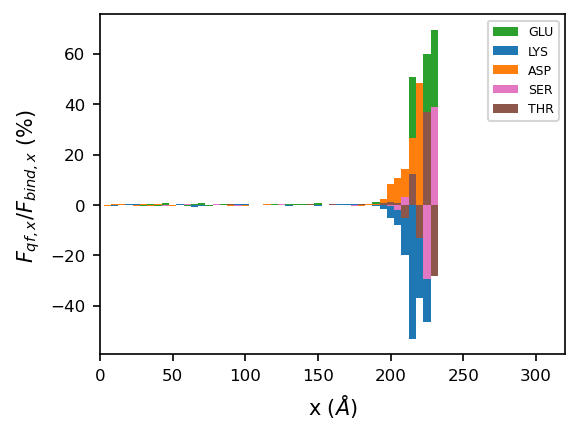

Max force in chain GLU: 69.51, slice location 230
Max force in chain LYS: 53.03, slice location 215
Max force in chain ASP: 48.26, slice location 220
Max force in chain SER: 39.00, slice location 230
Max force in chain THR: 36.96, slice location 225
Max force in chain ARG: 29.54, slice location 215
Max force in chain ASN: 12.11, slice location 230
Max force in chain TYR: 9.77, slice location 225
Max force in chain ALA: 8.59, slice location 220
Max force in chain ILE: 8.29, slice location 210
Max force in chain GLY: 6.27, slice location 210
Max force in chain GLN: 5.65, slice location 215
Max force in chain LEU: 5.59, slice location 215
Max force in chain PRO: 4.89, slice location 210
Max force in chain CYX: 4.42, slice location 215
Max force in chain VAL: 3.18, slice location 220
Max force in chain MET: 3.07, slice location 220
Max force in chain PHE: 2.62, slice location 215
Max force in chain TRP: 2.15, slice location 210
Max force in chain HIE: 1.25, slice location 225
Max force in 

In [51]:
# identify amino acids names or chains
h= 5
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(0,235,h,fqf_386,types,position,amino_acid_name,case)


plt.clf()
plt.figure(figsize=(4,3),dpi=150)
# Minus sign in forces to follow the convention of the paper
plt.bar(planes, f_porcent_chain_mag[top_aa[0]],width=h,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[1]],width=h,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[3]],width=h,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[4]],width=h,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xlim([0,320]); plt.xticks(numpy.arange(0,350,50))
plt.savefig('plots\\forces_qf_condelta_bar_{0}_4a_{1}.pdf'.format(str(h),case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

# Verification of the most important amino acids by force magnitude
f_porcent_chain_mag_sorted = sorted(f_porcent_chain_mag.items(), key=lambda x: max(abs(x[1])), reverse=True)   
planes_fmax = []
aminoacid_fmax = []
for chain, forces in f_porcent_chain_mag_sorted:
    print('Max force in chain %s: %.2f, slice location %.1d' %(chain,max(abs(forces)),planes[numpy.argmax(abs(forces))]))
    planes_fmax.append(planes[numpy.argmax(abs(forces))])
    aminoacid_fmax.append(chain)


### Figure 4b)

<Figure size 432x288 with 0 Axes>

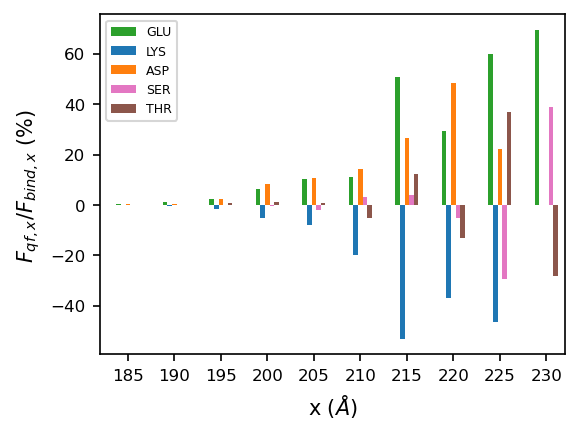

In [52]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4b_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c)

In [53]:
#count amino_acid_name in the file
n_aminoacid = dict()
for aminoacid in types:
    aminoacid_name = aminoacid.decode('utf-8')
    n_aminoacid[aminoacid_name] = len(numpy.where(aminoacid == amino_acid_name)[0])

# sort by number of atoms in n_aminoacid
n_aminoacid_sorted = sorted(n_aminoacid.items(), key=lambda x: x[1], reverse=True)   
print('Total number of atoms:', len(atom_name))
print('Total number of amino acids atoms:', sum(n_aminoacid.values()))
n_aminoacid_sorted

Total number of atoms: 1576628
Total number of amino acids atoms: 1576628


[('LEU', 188100),
 ('LYS', 126632),
 ('VAL', 118080),
 ('THR', 115920),
 ('ARG', 99360),
 ('ILE', 96120),
 ('SER', 87300),
 ('ALA', 85140),
 ('GLU', 78180),
 ('GLY', 71820),
 ('PHE', 68400),
 ('MET', 58140),
 ('HIE', 58140),
 ('TRP', 56160),
 ('ASP', 53952),
 ('TYR', 49140),
 ('GLN', 48960),
 ('PRO', 47880),
 ('ASN', 45360),
 ('CYX', 21600),
 ('CYS', 1980),
 ('GLH', 128),
 ('LYN', 84),
 ('ASH', 52)]

<Figure size 432x288 with 0 Axes>

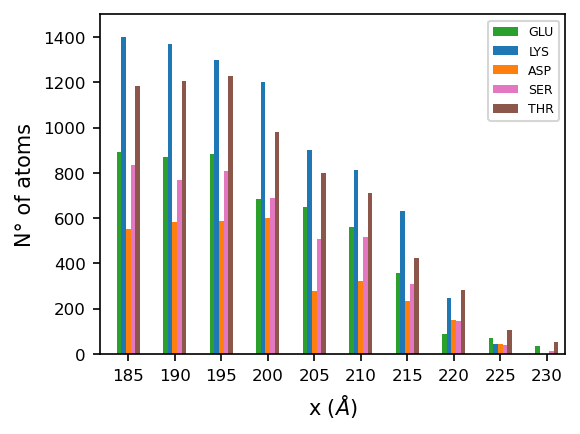

In [54]:
h= 5
planes, n_atoms = get_atoms_aminoacid_planes(0,235,h,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, n_atoms[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes+h/10, n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'N° of atoms')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.ylim([0,1500])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c) extra

<ipython-input-55-e4b6da190197>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1])
<ipython-input-55-e4b6da190197>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])


<Figure size 432x288 with 0 Axes>

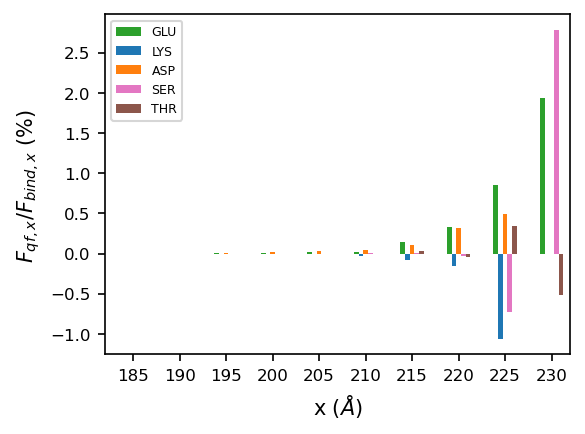

In [55]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, (f_porcent_chain_mag[top_aa[0]] / n_atoms[top_aa[0]]) ,width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]]/n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]]/n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_extra_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Net charge calculation in slices

In [56]:
planes, qnet_chain = get_qnet_planes(-285,285,h,q,types,position,amino_acid_name)
qnet_chain_sorted = sorted(qnet_chain.items(), key=lambda x: max(x[1]), reverse=True)   
for chain, charge in qnet_chain_sorted:
    print('Max charge in chain %s: %.2f, slice location %.1d' %(chain,max(charge),planes[numpy.argmax(charge)]))

Max charge in chain LYS: 81.98, slice location -155
Max charge in chain ARG: 67.10, slice location -170
Max charge in chain GLY: 11.71, slice location -75
Max charge in chain ILE: 10.11, slice location 0
Max charge in chain ASN: 7.51, slice location -5
Max charge in chain THR: 7.45, slice location 100
Max charge in chain VAL: 7.28, slice location -135
Max charge in chain ALA: 7.23, slice location -55
Max charge in chain LEU: 7.03, slice location -115
Max charge in chain SER: 6.94, slice location -200
Max charge in chain HIE: 6.46, slice location -135
Max charge in chain PHE: 6.09, slice location -10
Max charge in chain PRO: 5.46, slice location -30
Max charge in chain GLN: 5.10, slice location 0
Max charge in chain TRP: 4.91, slice location 90
Max charge in chain MET: 4.16, slice location -150
Max charge in chain CYX: 3.58, slice location -95
Max charge in chain TYR: 3.43, slice location -140
Max charge in chain CYS: 1.56, slice location 0
Max charge in chain LYN: 0.68, slice location 

In [57]:
#Net charge per slices in max force location order
for j in range(len(planes_fmax)):
    index = numpy.where(planes == planes_fmax[j])[0][0]
    print('Max charge in chain %s: %.2f, slice location %.1d' %(aminoacid_fmax[j],qnet_chain[aminoacid_fmax[j]][index],planes[index]))

Max charge in chain GLU: -2.42, slice location 230
Max charge in chain LYS: 30.31, slice location 215
Max charge in chain ASP: -14.00, slice location 220
Max charge in chain SER: -1.19, slice location 230
Max charge in chain THR: -1.78, slice location 225
Max charge in chain ARG: 10.46, slice location 215
Max charge in chain ASN: 0.75, slice location 230
Max charge in chain TYR: 0.51, slice location 225
Max charge in chain ALA: 2.22, slice location 220
Max charge in chain ILE: 5.23, slice location 210
Max charge in chain GLY: 3.68, slice location 210
Max charge in chain GLN: 1.40, slice location 215
Max charge in chain LEU: 1.69, slice location 215
Max charge in chain PRO: -0.53, slice location 210
Max charge in chain CYX: 1.29, slice location 215
Max charge in chain VAL: 0.53, slice location 220
Max charge in chain MET: -0.39, slice location 220
Max charge in chain PHE: 1.05, slice location 215
Max charge in chain TRP: -0.96, slice location 210
Max charge in chain HIE: 0.16, slice loc

## Simulation for cone

### Read dphir.txt files from Pygbe

In [4]:
folder='zika_afm\\sysBunchAnalysisCones\\zatsc' #Folder containing dphir.txt files
case = 'cone' #sphere, cone, cone_40_mM, cone_20_mM
f_tot_mag_386, top_aa, top_aa_color = select_case(case)
dphi_386c = numpy.loadtxt(folder+'386/dphir.txt')   # d=0.2nm
#dphi_390c = numpy.loadtxt(folder+'390/dphir.txt')   # d=0.6nm
#dphi_394c = numpy.loadtxt(folder+'394/dphir.txt')   # d=1.0nm
#dphi_404c = numpy.loadtxt(folder+'404/dphir.txt')   # d=2.0nm
#dphi_484c = numpy.loadtxt(folder+'484/dphir.txt')   # d=10.0nm
dphi_1384c = numpy.loadtxt(folder+'1384/dphir.txt') # d=100.0nm

# Read pqr file and calculate forces
N = len(dphi_386c)
position, q, amino_acid_name, amino_acid_number, atom_name, chain = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
delta_dphi_386_local = dphi_386c - dphi_1384c #Calculate interaction potential
fqf_386, fqf_mag_386, Fqf_386, Fqf_mag_386 = compute_force(delta_dphi_386_local, q)

# Identify aminoacids in .pqr file
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

### Figure 3a)

Plane z = 0
Atoms with force greater than 1% of the total force:  193
Atoms displaced by more than +-0.5 Angstrom:  4599
Atoms displaced by more than +-2.5 Angstrom:  22883
Total force for atoms greater than 1% of the total force:  [-1.14103101 -0.01659661  0.13013736]
Total force in slice:  [-0.18120239 -0.05128138  0.04441408]


<Figure size 432x288 with 0 Axes>

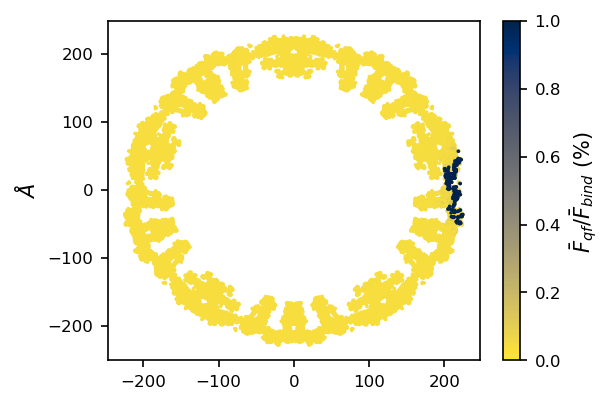

In [59]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plane = 0#-145.25
near_plane = numpy.where(abs(position[:,2]-plane)<0.5)[0] # Atoms between +-0.5 A
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A

# Plotting
x = position[near_plane,0]
y = position[near_plane,1]
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386) #Force percentage
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage
f_greater  = numpy.where(f_porcent2 > 1)[0] #Detect forces greater than 1% of the total force
fqf_plane = fqf_386[near_plane2]
fqf_plane_greater = fqf_plane[f_greater]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(x2,y2,c=f_porcent2,s=0.5, cmap='cividis_r',vmin=-0.3)
plt.scatter(x2[f_greater],y2[f_greater],c=f_porcent2[f_greater],cmap='cividis_r',s=0.5,vmin=0,vmax=1)
plt.colorbar(label=r'$ \bar{F}_{qf} /  \bar{F}_{bind} $ (%) ')
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_3a_{0}.pdf'.format(case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane z =', plane)
print('Atoms with force greater than 1% of the total force: ', len(f_greater))
print('Atoms displaced by more than +-0.5 Angstrom: ', len(near_plane))
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane2))
print('Total force for atoms greater than 1% of the total force: ', numpy.sum(fqf_plane_greater,axis=0))
print('Total force in slice: ', numpy.sum(fqf_plane,axis=0))

### Figure 3a) extra

Plane z = 0


<Figure size 432x288 with 0 Axes>

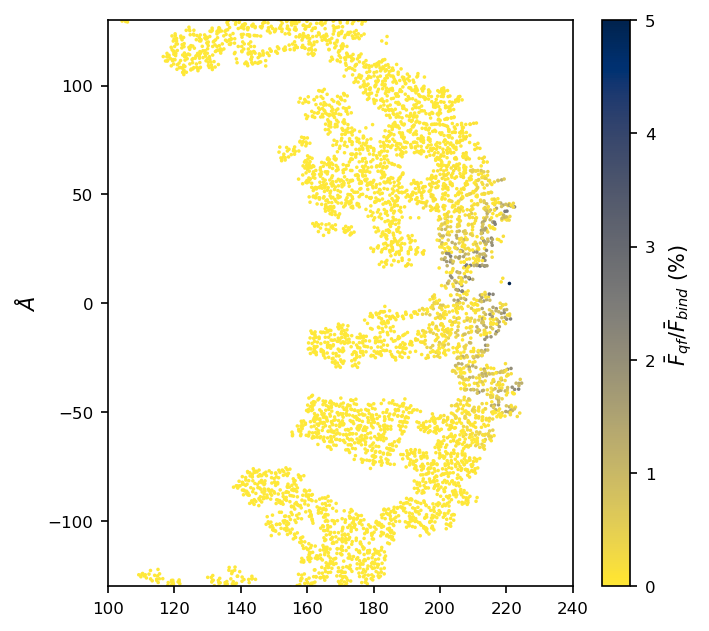

In [6]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plane = 0#-145.25
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A

# Plotting
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage

plt.clf()
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(x2,y2,c=f_porcent2,s=0.5, cmap='cividis_r',vmin=0,vmax=5)
plt.axis([100,240,-130,130])
plt.xticks(numpy.arange(100,250,20))
#plt.yticks(numpy.arange(-140,150,20))
plt.colorbar(label=r'$ \bar{F}_{qf} /  \bar{F}_{bind} $ (%) ')
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_3a_{0}_fullrange_v2.pdf'.format(case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane z =', plane)

### Figure 3b)

Plane x = 210
Atoms between +-2.5 Angstrom: 8053


<Figure size 432x288 with 0 Axes>

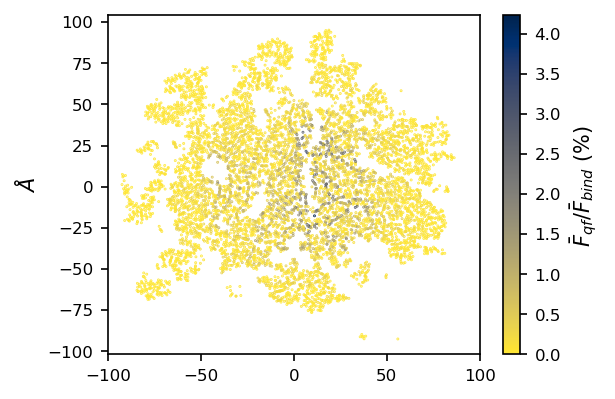

In [61]:
# Force qf plot for plane y-z (x=210) for capsid
# Select plane for the plot
plane = 210#-145.25
near_plane = numpy.where(abs(position[:,0]-plane)<2.5)[0]

# Plotting
y = position[near_plane,1]
z = position[near_plane,2]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386)
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y,z,c=f_porcent,cmap='cividis_r',vmin=0,marker='.',s=0.5)
plt.colorbar(label=r'$\bar{F}_{qf} /\bar{F}_{bind} $ (%) ')
plt.xlim([-100,100])
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_3b_{1}.pdf'.format(plane,case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane x =', plane)
print('Atoms between +-2.5 Angstrom:', len(near_plane))

### Figure 3c)

Plane x = 210
Atoms displaced by more than +-2.5 Angstrom:  8053
Atoms of GLU greater than 3.6% in slice  0
Total force for atoms of GLU greater than 3.6% of the total force:  [0. 0. 0.]
Atoms of LYS greater than 3.6% in slice  0
Total force for atoms of LYS greater than 3.6% of the total force:  [0. 0. 0.]
Atoms of ASP greater than 3.6% in slice  0
Total force for atoms of ASP greater than 3.6% of the total force:  [0. 0. 0.]
Total force in slice:  [ 0.39730594 -0.12857175  0.12023352]


<Figure size 432x288 with 0 Axes>

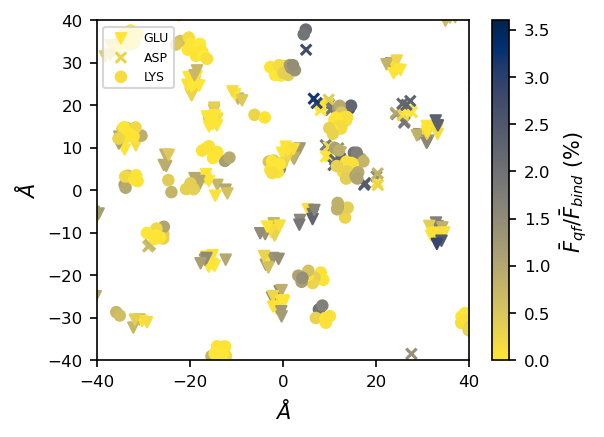

In [62]:
### Figure 3c)
# Plotting for each chain
plane = 210 #-145.25
near_plane_abs = numpy.where(abs(position[:,0]-plane)<2.5)[0] #Plane between +-1 angstrom
near_plane_GLU = numpy.where(amino_acid_name[near_plane_abs] == b'GLU')[0] #Selecting atoms of the chain GLU
near_plane_LYS = numpy.where(amino_acid_name[near_plane_abs] == b'LYS')[0] #Selecting atoms of the chain LYS
near_plane_ASP = numpy.where(amino_acid_name[near_plane_abs] == b'ASP')[0] #Selecting atoms of the chain ASP


# Plotting
y_GLU = position[near_plane_abs[near_plane_GLU],1]
z_GLU = position[near_plane_abs[near_plane_GLU],2]
f_porcent_GLU = 100*(fqf_mag_386[near_plane_abs[near_plane_GLU]])/(f_tot_mag_386)
f_greater_GLU = numpy.where(f_porcent_GLU > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_GLU = fqf_386[near_plane_abs[near_plane_GLU[f_greater_GLU]]]

y_LYS = position[near_plane_abs[near_plane_LYS],1]
z_LYS = position[near_plane_abs[near_plane_LYS],2]
f_porcent_LYS = 100*(fqf_mag_386[near_plane_abs[near_plane_LYS]])/(f_tot_mag_386)
f_greater_LYS = numpy.where(f_porcent_LYS > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_LYS = fqf_386[near_plane_abs[near_plane_LYS[f_greater_LYS]]]

y_ASP = position[near_plane_abs[near_plane_ASP],1]
z_ASP = position[near_plane_abs[near_plane_ASP],2]
f_porcent_ASP = 100*(fqf_mag_386[near_plane_abs[near_plane_ASP]])/(f_tot_mag_386)
f_greater_ASP = numpy.where(f_porcent_ASP > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_ASP = fqf_386[near_plane_abs[near_plane_ASP[f_greater_ASP]]]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y_GLU,z_GLU,c=f_porcent_GLU,s=25,cmap='cividis_r',marker='v',vmin=0,vmax=3.6,label='GLU')
plt.scatter(y_ASP,z_ASP,c=f_porcent_ASP,s=25,cmap='cividis_r',marker='x',vmin=0,vmax=3.6,label='ASP')
plt.scatter(y_LYS,z_LYS,c=f_porcent_LYS,s=25,cmap='cividis_r',marker='o',vmin=0,vmax=3.6,label='LYS')
plt.xlim([-40,40]); plt.ylim([-40,40])
plt.legend(loc='upper left',prop={'size': 6})
plt.ylabel('$\AA$')
plt.xlabel('$\AA$')
plt.colorbar(label=r'$\bar{F}_{qf} / \bar{F}_{bind}  $ (%) ')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_{1}_3c_{2}.pdf'.format(plane,'GLULYSASP',case), format='pdf',dpi=300,bbox_inches='tight')

print('Plane x =', plane)
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane_abs))
print('Atoms of GLU greater than 3.6% in slice ', len(fqf_plane_greater_GLU))
print('Total force for atoms of GLU greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_GLU,axis=0))
print('Atoms of LYS greater than 3.6% in slice ', len(fqf_plane_greater_LYS))
print('Total force for atoms of LYS greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_LYS,axis=0))
print('Atoms of ASP greater than 3.6% in slice ', len(fqf_plane_greater_ASP))
print('Total force for atoms of ASP greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_ASP,axis=0))
print('Total force in slice: ', numpy.sum(fqf_386[near_plane_abs] ,axis=0))

### Figure 4a)

<Figure size 432x288 with 0 Axes>

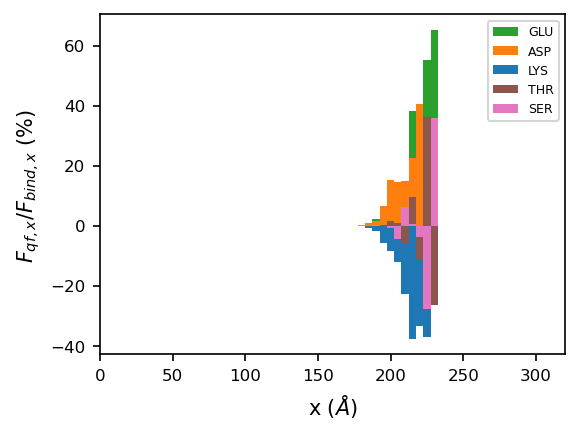

Max force in chain GLU: 65.27, slice location 230
Max force in chain ASP: 40.71, slice location 220
Max force in chain LYS: 37.60, slice location 215
Max force in chain THR: 36.27, slice location 225
Max force in chain SER: 35.75, slice location 230
Max force in chain ARG: 21.25, slice location 215
Max force in chain ASN: 11.47, slice location 230
Max force in chain ILE: 9.23, slice location 210
Max force in chain TYR: 8.93, slice location 225
Max force in chain ALA: 6.94, slice location 220
Max force in chain GLY: 4.83, slice location 210
Max force in chain GLN: 4.36, slice location 215
Max force in chain LEU: 3.97, slice location 220
Max force in chain PRO: 3.97, slice location 210
Max force in chain VAL: 3.45, slice location 210
Max force in chain CYX: 3.04, slice location 215
Max force in chain PHE: 2.67, slice location 215
Max force in chain TRP: 2.45, slice location 200
Max force in chain MET: 2.17, slice location 215
Max force in chain HIE: 1.38, slice location 215
Max force in 

In [63]:
# identify amino acids names or chains
h= 5
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(0,235,h,fqf_386,types,position,amino_acid_name,case)


plt.clf()
plt.figure(figsize=(4,3),dpi=150)
# Minus sign in forces to follow the convention of the paper
plt.bar(planes, f_porcent_chain_mag[top_aa[0]],width=h,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[1]],width=h,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[3]],width=h,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[4]],width=h,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xlim([0,320]); plt.xticks(numpy.arange(0,350,50))
plt.savefig('plots\\forces_qf_condelta_bar_{0}_4a_{1}.pdf'.format(str(h),case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

# Verification of the most important amino acids by force magnitude
f_porcent_chain_mag_sorted = sorted(f_porcent_chain_mag.items(), key=lambda x: max(abs(x[1])), reverse=True)   
planes_fmax = []
aminoacid_fmax = []
for chain, forces in f_porcent_chain_mag_sorted:
    print('Max force in chain %s: %.2f, slice location %.1d' %(chain,max(abs(forces)),planes[numpy.argmax(abs(forces))]))
    planes_fmax.append(planes[numpy.argmax(abs(forces))])
    aminoacid_fmax.append(chain)


### Figure 4b)

<Figure size 432x288 with 0 Axes>

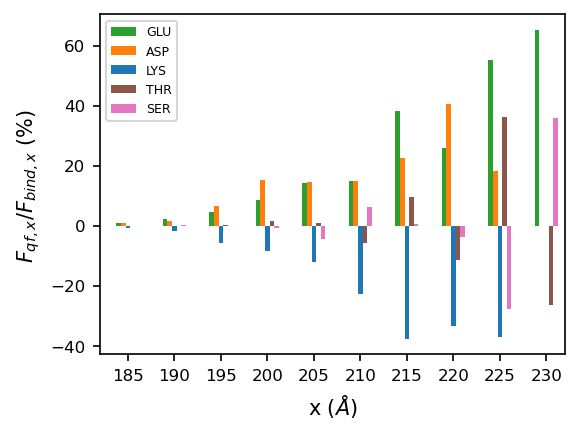

In [64]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4b_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c) 

In [65]:
#count amino_acid_name in the file
n_aminoacid = dict()
for aminoacid in types:
    aminoacid_name = aminoacid.decode('utf-8')
    n_aminoacid[aminoacid_name] = len(numpy.where(aminoacid == amino_acid_name)[0])

# sort by number of atoms in n_aminoacid
n_aminoacid_sorted = sorted(n_aminoacid.items(), key=lambda x: x[1], reverse=True)   
print('Total number of atoms:', len(atom_name))
print('Total number of amino acids atoms:', sum(n_aminoacid.values()))
n_aminoacid_sorted

Total number of atoms: 1576628
Total number of amino acids atoms: 1576628


[('LEU', 188100),
 ('LYS', 126632),
 ('VAL', 118080),
 ('THR', 115920),
 ('ARG', 99360),
 ('ILE', 96120),
 ('SER', 87300),
 ('ALA', 85140),
 ('GLU', 78180),
 ('GLY', 71820),
 ('PHE', 68400),
 ('MET', 58140),
 ('HIE', 58140),
 ('TRP', 56160),
 ('ASP', 53952),
 ('TYR', 49140),
 ('GLN', 48960),
 ('PRO', 47880),
 ('ASN', 45360),
 ('CYX', 21600),
 ('CYS', 1980),
 ('GLH', 128),
 ('LYN', 84),
 ('ASH', 52)]

<Figure size 432x288 with 0 Axes>

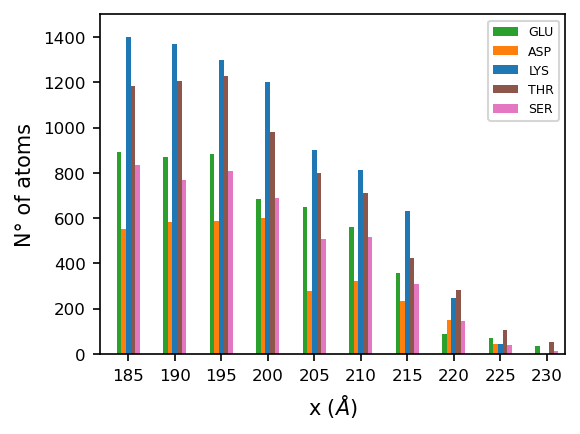

In [66]:
h= 5
planes, n_atoms = get_atoms_aminoacid_planes(0,235,h,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, n_atoms[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes+h/10, n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'N° of atoms')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.ylim([0,1500])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c) extra

<ipython-input-67-e4b6da190197>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1])
<ipython-input-67-e4b6da190197>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])


<Figure size 432x288 with 0 Axes>

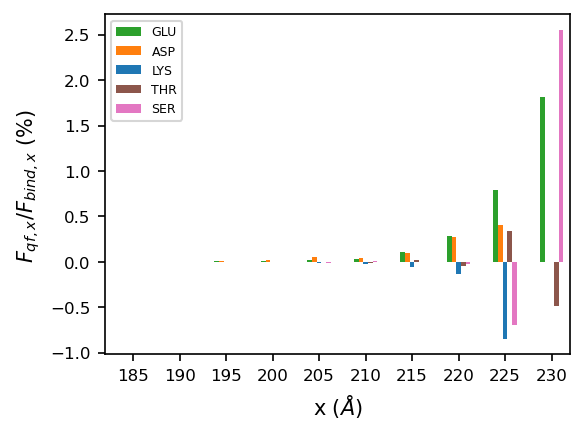

In [67]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, (f_porcent_chain_mag[top_aa[0]] / n_atoms[top_aa[0]]) ,width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]]/n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]]/n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_extra_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Net charge calculation in slices

In [68]:
planes, qnet_chain = get_qnet_planes(-285,285,h,q,types,position,amino_acid_name)
qnet_chain_sorted = sorted(qnet_chain.items(), key=lambda x: max(x[1]), reverse=True)   
for chain, charge in qnet_chain_sorted:
    print('Max charge in chain %s: %.2f, slice location %.1d' %(chain,max(charge),planes[numpy.argmax(charge)]))

Max charge in chain LYS: 81.98, slice location -155
Max charge in chain ARG: 67.10, slice location -170
Max charge in chain GLY: 11.71, slice location -75
Max charge in chain ILE: 10.11, slice location 0
Max charge in chain ASN: 7.51, slice location -5
Max charge in chain THR: 7.45, slice location 100
Max charge in chain VAL: 7.28, slice location -135
Max charge in chain ALA: 7.23, slice location -55
Max charge in chain LEU: 7.03, slice location -115
Max charge in chain SER: 6.94, slice location -200
Max charge in chain HIE: 6.46, slice location -135
Max charge in chain PHE: 6.09, slice location -10
Max charge in chain PRO: 5.46, slice location -30
Max charge in chain GLN: 5.10, slice location 0
Max charge in chain TRP: 4.91, slice location 90
Max charge in chain MET: 4.16, slice location -150
Max charge in chain CYX: 3.58, slice location -95
Max charge in chain TYR: 3.43, slice location -140
Max charge in chain CYS: 1.56, slice location 0
Max charge in chain LYN: 0.68, slice location 

In [69]:
#Net charge per slices in max force location order
for j in range(len(planes_fmax)):
    index = numpy.where(planes == planes_fmax[j])[0][0]
    print('Max charge in chain %s: %.2f, slice location %.1d' %(aminoacid_fmax[j],qnet_chain[aminoacid_fmax[j]][index],planes[index]))

Max charge in chain GLU: -2.42, slice location 230
Max charge in chain ASP: -14.00, slice location 220
Max charge in chain LYS: 30.31, slice location 215
Max charge in chain THR: -1.78, slice location 225
Max charge in chain SER: -1.19, slice location 230
Max charge in chain ARG: 10.46, slice location 215
Max charge in chain ASN: 0.75, slice location 230
Max charge in chain ILE: 5.23, slice location 210
Max charge in chain TYR: 0.51, slice location 225
Max charge in chain ALA: 2.22, slice location 220
Max charge in chain GLY: 3.68, slice location 210
Max charge in chain GLN: 1.40, slice location 215
Max charge in chain LEU: -0.42, slice location 220
Max charge in chain PRO: -0.53, slice location 210
Max charge in chain VAL: 0.03, slice location 210
Max charge in chain CYX: 1.29, slice location 215
Max charge in chain PHE: 1.05, slice location 215
Max charge in chain TRP: -3.80, slice location 200
Max charge in chain MET: 0.97, slice location 215
Max charge in chain HIE: 0.91, slice loc

## Simulation for cone 40 mM

### Read dphir.txt files from Pygbe

In [70]:
folder='zika_afm\\sysBunchAnalysisConesLSalt40mM\\zatsc' #Folder containing dphir.txt files
case = 'cone_40_mM' #sphere, cone, cone_40_mM, cone_20_mM
f_tot_mag_386, top_aa, top_aa_color = select_case(case)
dphi_386c = numpy.loadtxt(folder+'386/dphir.txt')   # d=0.2nm
#dphi_390c = numpy.loadtxt(folder+'390/dphir.txt')   # d=0.6nm
#dphi_394c = numpy.loadtxt(folder+'394/dphir.txt')   # d=1.0nm
#dphi_404c = numpy.loadtxt(folder+'404/dphir.txt')   # d=2.0nm
#dphi_484c = numpy.loadtxt(folder+'484/dphir.txt')   # d=10.0nm
dphi_1384c = numpy.loadtxt(folder+'1384/dphir.txt') # d=100.0nm

# Read pqr file and calculate forces
N = len(dphi_386c)
position, q, amino_acid_name, amino_acid_number, atom_name, chain = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
delta_dphi_386_local = dphi_386c - dphi_1384c #Calculate interaction potential
fqf_386, fqf_mag_386, Fqf_386, Fqf_mag_386 = compute_force(delta_dphi_386_local, q)

# Identify aminoacids in .pqr file
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

### Figure 3a)

Plane z = 0
Atoms with force greater than 1% of the total force:  548
Atoms displaced by more than +-0.5 Angstrom:  4599
Atoms displaced by more than +-2.5 Angstrom:  22883
Total force for atoms greater than 1% of the total force:  [-4.97472454 -0.28753515  0.65897893]
Total force in slice:  [-0.43362281 -0.34114739  0.20201399]


<Figure size 432x288 with 0 Axes>

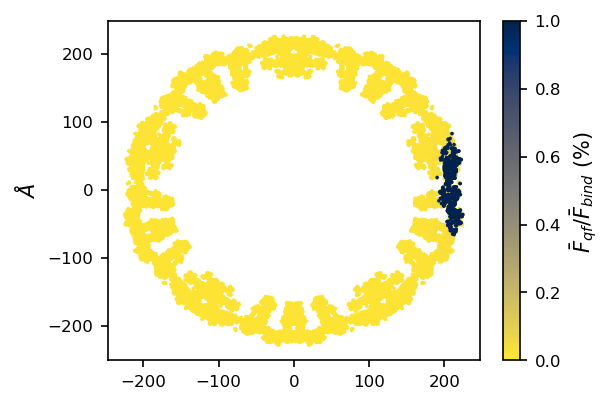

In [71]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plane = 0#-145.25
near_plane = numpy.where(abs(position[:,2]-plane)<0.5)[0] # Atoms between +-0.5 A
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A

# Plotting
x = position[near_plane,0]
y = position[near_plane,1]
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386) #Force percentage
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage
f_greater  = numpy.where(f_porcent2 > 1)[0] #Detect forces greater than 1% of the total force
fqf_plane = fqf_386[near_plane2]
fqf_plane_greater = fqf_plane[f_greater]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(x2,y2,c=f_porcent2,s=0.5, cmap='cividis_r',vmin=-0.3)
plt.scatter(x2[f_greater],y2[f_greater],c=f_porcent2[f_greater],cmap='cividis_r',s=0.5,vmin=0,vmax=1)
plt.colorbar(label=r'$ \bar{F}_{qf} /  \bar{F}_{bind} $ (%) ')
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_3a_{0}.pdf'.format(case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane z =', plane)
print('Atoms with force greater than 1% of the total force: ', len(f_greater))
print('Atoms displaced by more than +-0.5 Angstrom: ', len(near_plane))
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane2))
print('Total force for atoms greater than 1% of the total force: ', numpy.sum(fqf_plane_greater,axis=0))
print('Total force in slice: ', numpy.sum(fqf_plane,axis=0))

### Figure 3b)

Plane x = 210
Atoms between +-2.5 Angstrom: 8053


<Figure size 432x288 with 0 Axes>

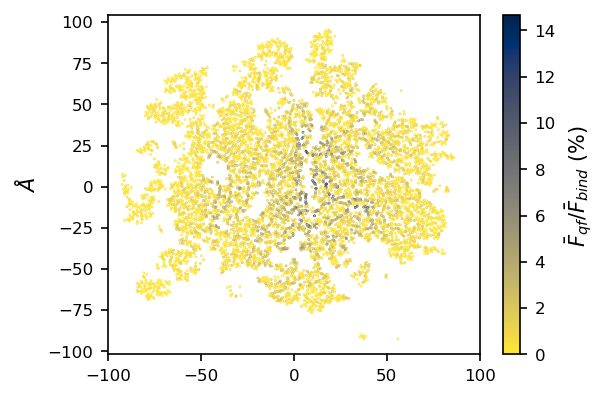

In [72]:
# Force qf plot for plane y-z (x=210) for capsid
# Select plane for the plot
plane = 210#-145.25
near_plane = numpy.where(abs(position[:,0]-plane)<2.5)[0]

# Plotting
y = position[near_plane,1]
z = position[near_plane,2]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386)
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y,z,c=f_porcent,cmap='cividis_r',vmin=0,marker='.',s=0.5)
plt.colorbar(label=r'$\bar{F}_{qf} /\bar{F}_{bind} $ (%) ')
plt.xlim([-100,100])
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_3b_{1}.pdf'.format(plane,case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane x =', plane)
print('Atoms between +-2.5 Angstrom:', len(near_plane))

### Figure 3c)

Plane x = 210
Atoms displaced by more than +-2.5 Angstrom:  8053
Atoms of GLU greater than 3.6% in slice  47
Total force for atoms of GLU greater than 3.6% of the total force:  [-2.02139158 -0.29447619  0.01493535]
Atoms of LYS greater than 3.6% in slice  31
Total force for atoms of LYS greater than 3.6% of the total force:  [ 1.52204434 -0.22433124  0.05710109]
Atoms of ASP greater than 3.6% in slice  25
Total force for atoms of ASP greater than 3.6% of the total force:  [-1.90825245  0.19927249  0.34221283]
Total force in slice:  [ 2.07321604 -0.84110269  0.70317805]


<Figure size 432x288 with 0 Axes>

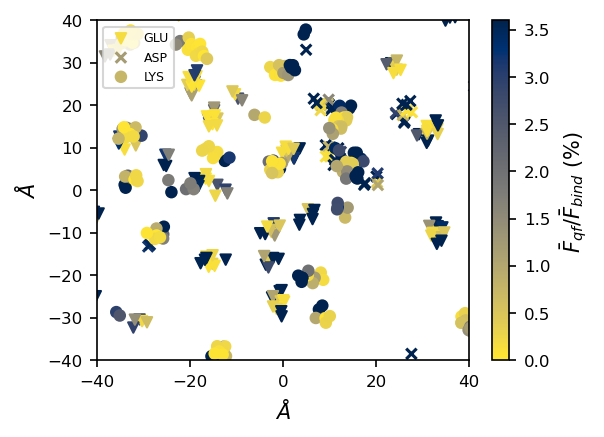

In [73]:
### Figure 3c)
# Plotting for each chain
plane = 210 #-145.25
near_plane_abs = numpy.where(abs(position[:,0]-plane)<2.5)[0] #Plane between +-1 angstrom
near_plane_GLU = numpy.where(amino_acid_name[near_plane_abs] == b'GLU')[0] #Selecting atoms of the chain GLU
near_plane_LYS = numpy.where(amino_acid_name[near_plane_abs] == b'LYS')[0] #Selecting atoms of the chain LYS
near_plane_ASP = numpy.where(amino_acid_name[near_plane_abs] == b'ASP')[0] #Selecting atoms of the chain ASP


# Plotting
y_GLU = position[near_plane_abs[near_plane_GLU],1]
z_GLU = position[near_plane_abs[near_plane_GLU],2]
f_porcent_GLU = 100*(fqf_mag_386[near_plane_abs[near_plane_GLU]])/(f_tot_mag_386)
f_greater_GLU = numpy.where(f_porcent_GLU > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_GLU = fqf_386[near_plane_abs[near_plane_GLU[f_greater_GLU]]]

y_LYS = position[near_plane_abs[near_plane_LYS],1]
z_LYS = position[near_plane_abs[near_plane_LYS],2]
f_porcent_LYS = 100*(fqf_mag_386[near_plane_abs[near_plane_LYS]])/(f_tot_mag_386)
f_greater_LYS = numpy.where(f_porcent_LYS > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_LYS = fqf_386[near_plane_abs[near_plane_LYS[f_greater_LYS]]]

y_ASP = position[near_plane_abs[near_plane_ASP],1]
z_ASP = position[near_plane_abs[near_plane_ASP],2]
f_porcent_ASP = 100*(fqf_mag_386[near_plane_abs[near_plane_ASP]])/(f_tot_mag_386)
f_greater_ASP = numpy.where(f_porcent_ASP > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_ASP = fqf_386[near_plane_abs[near_plane_ASP[f_greater_ASP]]]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y_GLU,z_GLU,c=f_porcent_GLU,s=25,cmap='cividis_r',marker='v',vmin=0,vmax=3.6,label='GLU')
plt.scatter(y_ASP,z_ASP,c=f_porcent_ASP,s=25,cmap='cividis_r',marker='x',vmin=0,vmax=3.6,label='ASP')
plt.scatter(y_LYS,z_LYS,c=f_porcent_LYS,s=25,cmap='cividis_r',marker='o',vmin=0,vmax=3.6,label='LYS')
plt.xlim([-40,40]); plt.ylim([-40,40])
plt.legend(loc='upper left',prop={'size': 6})
plt.ylabel('$\AA$')
plt.xlabel('$\AA$')
plt.colorbar(label=r'$\bar{F}_{qf} / \bar{F}_{bind}  $ (%) ')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_{1}_3c_{2}.pdf'.format(plane,'GLULYSASP',case), format='pdf',dpi=300,bbox_inches='tight')

print('Plane x =', plane)
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane_abs))
print('Atoms of GLU greater than 3.6% in slice ', len(fqf_plane_greater_GLU))
print('Total force for atoms of GLU greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_GLU,axis=0))
print('Atoms of LYS greater than 3.6% in slice ', len(fqf_plane_greater_LYS))
print('Total force for atoms of LYS greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_LYS,axis=0))
print('Atoms of ASP greater than 3.6% in slice ', len(fqf_plane_greater_ASP))
print('Total force for atoms of ASP greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_ASP,axis=0))
print('Total force in slice: ', numpy.sum(fqf_386[near_plane_abs] ,axis=0))

### Figure 4a)

<Figure size 432x288 with 0 Axes>

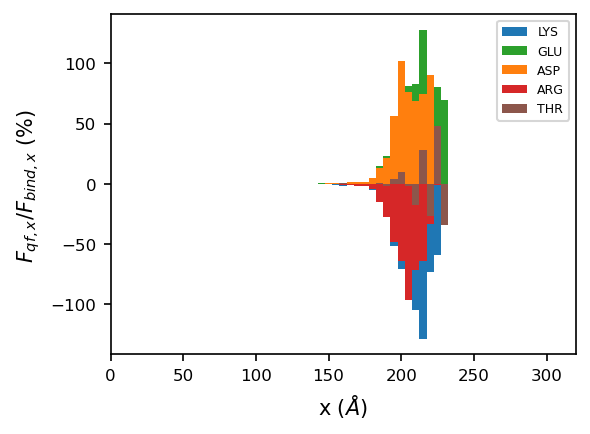

Max force in chain LYS: 128.45, slice location 215
Max force in chain GLU: 127.87, slice location 215
Max force in chain ASP: 101.88, slice location 200
Max force in chain ARG: 96.31, slice location 205
Max force in chain THR: 48.40, slice location 225
Max force in chain SER: 45.40, slice location 230
Max force in chain ILE: 34.81, slice location 210
Max force in chain ASN: 21.92, slice location 215
Max force in chain GLY: 20.01, slice location 210
Max force in chain ALA: 17.82, slice location 220
Max force in chain TYR: 13.45, slice location 225
Max force in chain GLN: 12.75, slice location 215
Max force in chain TRP: 11.74, slice location 200
Max force in chain VAL: 10.44, slice location 210
Max force in chain PRO: 9.72, slice location 215
Max force in chain LEU: 8.80, slice location 215
Max force in chain CYX: 8.65, slice location 215
Max force in chain PHE: 7.43, slice location 215
Max force in chain MET: 6.72, slice location 215
Max force in chain HIE: 6.49, slice location 195
Max

In [74]:
# identify amino acids names or chains
h= 5
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(0,235,h,fqf_386,types,position,amino_acid_name,case)


plt.clf()
plt.figure(figsize=(4,3),dpi=150)
# Minus sign in forces to follow the convention of the paper
plt.bar(planes, f_porcent_chain_mag[top_aa[0]],width=h,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[1]],width=h,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[3]],width=h,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[4]],width=h,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xlim([0,320]); plt.xticks(numpy.arange(0,350,50))
plt.savefig('plots\\forces_qf_condelta_bar_{0}_4a_{1}.pdf'.format(str(h),case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

# Verification of the most important amino acids by force magnitude
f_porcent_chain_mag_sorted = sorted(f_porcent_chain_mag.items(), key=lambda x: max(abs(x[1])), reverse=True)   
planes_fmax = []
aminoacid_fmax = []
for chain, forces in f_porcent_chain_mag_sorted:
    print('Max force in chain %s: %.2f, slice location %.1d' %(chain,max(abs(forces)),planes[numpy.argmax(abs(forces))]))
    planes_fmax.append(planes[numpy.argmax(abs(forces))])
    aminoacid_fmax.append(chain)


### Figure 4b)

<Figure size 432x288 with 0 Axes>

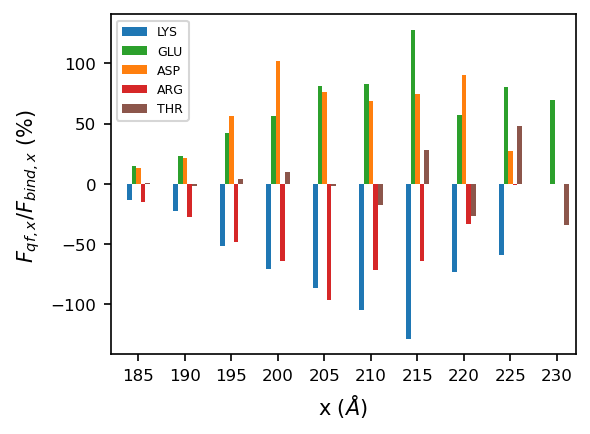

In [75]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4b_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c)

In [76]:
#count amino_acid_name in the file
n_aminoacid = dict()
for aminoacid in types:
    aminoacid_name = aminoacid.decode('utf-8')
    n_aminoacid[aminoacid_name] = len(numpy.where(aminoacid == amino_acid_name)[0])

# sort by number of atoms in n_aminoacid
n_aminoacid_sorted = sorted(n_aminoacid.items(), key=lambda x: x[1], reverse=True)   
print('Total number of atoms:', len(atom_name))
print('Total number of amino acids atoms:', sum(n_aminoacid.values()))
n_aminoacid_sorted

Total number of atoms: 1576628
Total number of amino acids atoms: 1576628


[('LEU', 188100),
 ('LYS', 126632),
 ('VAL', 118080),
 ('THR', 115920),
 ('ARG', 99360),
 ('ILE', 96120),
 ('SER', 87300),
 ('ALA', 85140),
 ('GLU', 78180),
 ('GLY', 71820),
 ('PHE', 68400),
 ('MET', 58140),
 ('HIE', 58140),
 ('TRP', 56160),
 ('ASP', 53952),
 ('TYR', 49140),
 ('GLN', 48960),
 ('PRO', 47880),
 ('ASN', 45360),
 ('CYX', 21600),
 ('CYS', 1980),
 ('GLH', 128),
 ('LYN', 84),
 ('ASH', 52)]

<Figure size 432x288 with 0 Axes>

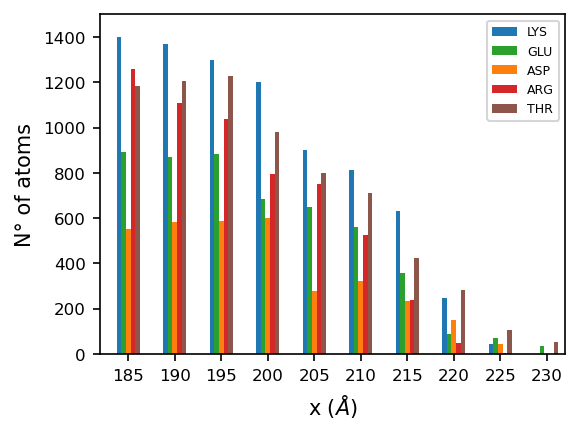

In [77]:
h= 5
planes, n_atoms = get_atoms_aminoacid_planes(0,235,h,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, n_atoms[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes+h/10, n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'N° of atoms')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.ylim([0,1500])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c) extra

<ipython-input-78-e4b6da190197>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes-2*h/10, (f_porcent_chain_mag[top_aa[0]] / n_atoms[top_aa[0]]) ,width=h/10,label=top_aa[0],color=top_aa_color[0])
<ipython-input-78-e4b6da190197>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
<ipython-input-78-e4b6da190197>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]]/n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3])


<Figure size 432x288 with 0 Axes>

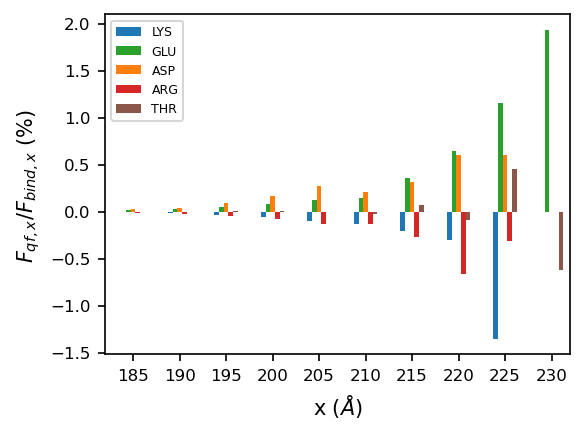

In [78]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, (f_porcent_chain_mag[top_aa[0]] / n_atoms[top_aa[0]]) ,width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]]/n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]]/n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_extra_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Net charge calculation in slices

In [79]:
planes, qnet_chain = get_qnet_planes(-285,285,h,q,types,position,amino_acid_name)
qnet_chain_sorted = sorted(qnet_chain.items(), key=lambda x: max(x[1]), reverse=True)   
for chain, charge in qnet_chain_sorted:
    print('Max charge in chain %s: %.2f, slice location %.1d' %(chain,max(charge),planes[numpy.argmax(charge)]))

Max charge in chain LYS: 81.98, slice location -155
Max charge in chain ARG: 67.10, slice location -170
Max charge in chain GLY: 11.71, slice location -75
Max charge in chain ILE: 10.11, slice location 0
Max charge in chain ASN: 7.51, slice location -5
Max charge in chain THR: 7.45, slice location 100
Max charge in chain VAL: 7.28, slice location -135
Max charge in chain ALA: 7.23, slice location -55
Max charge in chain LEU: 7.03, slice location -115
Max charge in chain SER: 6.94, slice location -200
Max charge in chain HIE: 6.46, slice location -135
Max charge in chain PHE: 6.09, slice location -10
Max charge in chain PRO: 5.46, slice location -30
Max charge in chain GLN: 5.10, slice location 0
Max charge in chain TRP: 4.91, slice location 90
Max charge in chain MET: 4.16, slice location -150
Max charge in chain CYX: 3.58, slice location -95
Max charge in chain TYR: 3.43, slice location -140
Max charge in chain CYS: 1.56, slice location 0
Max charge in chain LYN: 0.68, slice location 

In [80]:
#Net charge per slices in max force location order
for j in range(len(planes_fmax)):
    index = numpy.where(planes == planes_fmax[j])[0][0]
    print('Max charge in chain %s: %.2f, slice location %.1d' %(aminoacid_fmax[j],qnet_chain[aminoacid_fmax[j]][index],planes[index]))

Max charge in chain LYS: 30.31, slice location 215
Max charge in chain GLU: -30.61, slice location 215
Max charge in chain ASP: -42.29, slice location 200
Max charge in chain ARG: 30.92, slice location 205
Max charge in chain THR: -1.78, slice location 225
Max charge in chain SER: -1.19, slice location 230
Max charge in chain ILE: 5.23, slice location 210
Max charge in chain ASN: 1.91, slice location 215
Max charge in chain GLY: 3.68, slice location 210
Max charge in chain ALA: 2.22, slice location 220
Max charge in chain TYR: 0.51, slice location 225
Max charge in chain GLN: 1.40, slice location 215
Max charge in chain TRP: -3.80, slice location 200
Max charge in chain VAL: 0.03, slice location 210
Max charge in chain PRO: 0.21, slice location 215
Max charge in chain LEU: 1.69, slice location 215
Max charge in chain CYX: 1.29, slice location 215
Max charge in chain PHE: 1.05, slice location 215
Max charge in chain MET: 0.97, slice location 215
Max charge in chain HIE: 5.03, slice loca

## Simulation for cone 20 mM

### Read dphir.txt files from Pygbe

In [7]:
folder='zika_afm\\sysBunchAnalysisConesLSalt20mM\\zatsc' #Folder containing dphir.txt files
case = 'cone_20_mM' #sphere, cone, cone_40_mM, cone_20_mM
f_tot_mag_386, top_aa, top_aa_color = select_case(case)
dphi_386c = numpy.loadtxt(folder+'386/dphir.txt')   # d=0.2nm
#dphi_390c = numpy.loadtxt(folder+'390/dphir.txt')   # d=0.6nm
#dphi_394c = numpy.loadtxt(folder+'394/dphir.txt')   # d=1.0nm
#dphi_404c = numpy.loadtxt(folder+'404/dphir.txt')   # d=2.0nm
#dphi_484c = numpy.loadtxt(folder+'484/dphir.txt')   # d=10.0nm
dphi_1384c = numpy.loadtxt(folder+'1384/dphir.txt') # d=100.0nm

# Read pqr file and calculate forces
N = len(dphi_386c)
position, q, amino_acid_name, amino_acid_number, atom_name, chain = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
delta_dphi_386_local = dphi_386c - dphi_1384c #Calculate interaction potential
fqf_386, fqf_mag_386, Fqf_386, Fqf_mag_386 = compute_force(delta_dphi_386_local, q)

# Identify aminoacids in .pqr file
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

### Figure 3a)

Plane z = 0
Atoms with force greater than 1% of the total force:  1000
Atoms displaced by more than +-0.5 Angstrom:  4599
Atoms displaced by more than +-2.5 Angstrom:  22883
Total force for atoms greater than 1% of the total force:  [-7.54908513 -0.87660163  0.89451527]
Total force in slice:  [-0.32849232 -0.57205476  0.275968  ]


<Figure size 432x288 with 0 Axes>

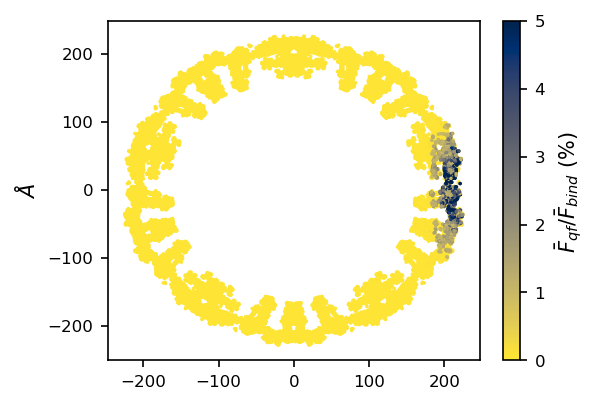

In [83]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plane = 0#-145.25
near_plane = numpy.where(abs(position[:,2]-plane)<0.5)[0] # Atoms between +-0.5 A
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A

# Plotting
x = position[near_plane,0]
y = position[near_plane,1]
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386) #Force percentage
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage
f_greater  = numpy.where(f_porcent2 > 1)[0] #Detect forces greater than 1% of the total force
fqf_plane = fqf_386[near_plane2]
fqf_plane_greater = fqf_plane[f_greater]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(x2,y2,c=f_porcent2,s=0.5, cmap='cividis_r',vmin=-0.3)
plt.scatter(x2[f_greater],y2[f_greater],c=f_porcent2[f_greater],cmap='cividis_r',s=0.5,vmin=0,vmax=5)
plt.colorbar(label=r'$ \bar{F}_{qf} /  \bar{F}_{bind} $ (%) ')
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_3a_{0}.pdf'.format(case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane z =', plane)
print('Atoms with force greater than 1% of the total force: ', len(f_greater))
print('Atoms displaced by more than +-0.5 Angstrom: ', len(near_plane))
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane2))
print('Total force for atoms greater than 1% of the total force: ', numpy.sum(fqf_plane_greater,axis=0))
print('Total force in slice: ', numpy.sum(fqf_plane,axis=0))

### Figura 3a) Full range

Plane z = 0


<Figure size 432x288 with 0 Axes>

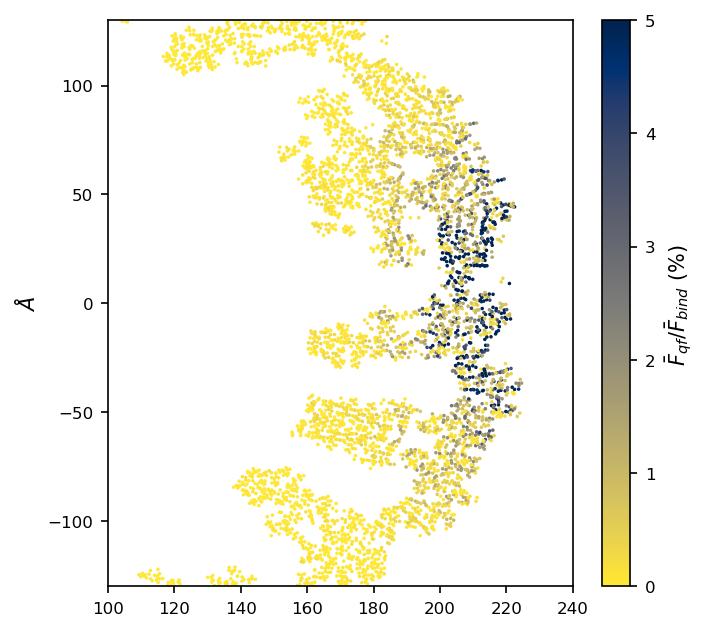

In [8]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plane = 0#-145.25
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A

# Plotting
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage

plt.clf()
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(x2,y2,c=f_porcent2,s=0.5, cmap='cividis_r',vmin=0,vmax=5)
plt.axis([100,240,-130,130])
plt.xticks(numpy.arange(100,250,20))
#plt.yticks(numpy.arange(-140,150,20))
plt.colorbar(label=r'$ \bar{F}_{qf} /  \bar{F}_{bind} $ (%) ')
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_3a_{0}_fullrange_v2.pdf'.format(case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane z =', plane)


### Figure 3b)

Plane x = 210
Atoms between +-2.5 Angstrom: 8053


<Figure size 432x288 with 0 Axes>

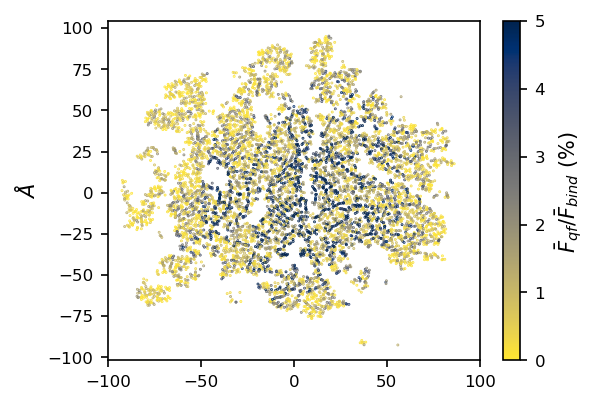

In [85]:
# Force qf plot for plane y-z (x=210) for capsid
# Select plane for the plot
plane = 210#-145.25
near_plane = numpy.where(abs(position[:,0]-plane)<2.5)[0]

# Plotting
y = position[near_plane,1]
z = position[near_plane,2]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386)
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y,z,c=f_porcent,cmap='cividis_r',vmin=0,marker='.',s=0.5,vmax=5)
plt.colorbar(label=r'$\bar{F}_{qf} /\bar{F}_{bind} $ (%) ')
plt.xlim([-100,100])
plt.ylabel('$\AA$')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_3b_{1}.pdf'.format(plane,case), format='pdf',dpi=300,bbox_inches='tight')
print('Plane x =', plane)
print('Atoms between +-2.5 Angstrom:', len(near_plane))

### Figure 3c)

Plane x = 210
Atoms displaced by more than +-2.5 Angstrom:  8053
Atoms of GLU greater than 3.6% in slice  136
Total force for atoms of GLU greater than 3.6% of the total force:  [-5.87509574 -0.95804693 -0.4521785 ]
Atoms of LYS greater than 3.6% in slice  86
Total force for atoms of LYS greater than 3.6% of the total force:  [ 3.00675955 -0.82258661 -0.13467567]
Atoms of ASP greater than 3.6% in slice  60
Total force for atoms of ASP greater than 3.6% of the total force:  [-4.21521551  0.8998314   0.41191378]
Total force in slice:  [ 3.27972137 -1.43189356  1.16455363]


<Figure size 432x288 with 0 Axes>

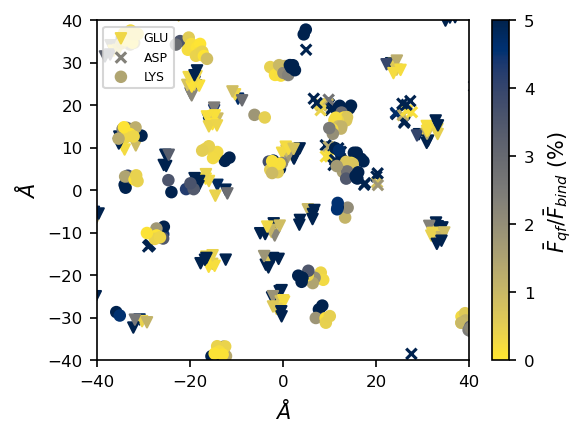

In [86]:
### Figure 3c)
# Plotting for each chain
plane = 210 #-145.25
near_plane_abs = numpy.where(abs(position[:,0]-plane)<2.5)[0] #Plane between +-1 angstrom
near_plane_GLU = numpy.where(amino_acid_name[near_plane_abs] == b'GLU')[0] #Selecting atoms of the chain GLU
near_plane_LYS = numpy.where(amino_acid_name[near_plane_abs] == b'LYS')[0] #Selecting atoms of the chain LYS
near_plane_ASP = numpy.where(amino_acid_name[near_plane_abs] == b'ASP')[0] #Selecting atoms of the chain ASP


# Plotting
y_GLU = position[near_plane_abs[near_plane_GLU],1]
z_GLU = position[near_plane_abs[near_plane_GLU],2]
f_porcent_GLU = 100*(fqf_mag_386[near_plane_abs[near_plane_GLU]])/(f_tot_mag_386)
f_greater_GLU = numpy.where(f_porcent_GLU > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_GLU = fqf_386[near_plane_abs[near_plane_GLU[f_greater_GLU]]]

y_LYS = position[near_plane_abs[near_plane_LYS],1]
z_LYS = position[near_plane_abs[near_plane_LYS],2]
f_porcent_LYS = 100*(fqf_mag_386[near_plane_abs[near_plane_LYS]])/(f_tot_mag_386)
f_greater_LYS = numpy.where(f_porcent_LYS > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_LYS = fqf_386[near_plane_abs[near_plane_LYS[f_greater_LYS]]]

y_ASP = position[near_plane_abs[near_plane_ASP],1]
z_ASP = position[near_plane_abs[near_plane_ASP],2]
f_porcent_ASP = 100*(fqf_mag_386[near_plane_abs[near_plane_ASP]])/(f_tot_mag_386)
f_greater_ASP = numpy.where(f_porcent_ASP > 3.6)[0] #Detect forces greater than 3.6% of the total force
fqf_plane_greater_ASP = fqf_386[near_plane_abs[near_plane_ASP[f_greater_ASP]]]

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y_GLU,z_GLU,c=f_porcent_GLU,s=25,cmap='cividis_r',marker='v',vmin=0,vmax=5,label='GLU')
plt.scatter(y_ASP,z_ASP,c=f_porcent_ASP,s=25,cmap='cividis_r',marker='x',vmin=0,vmax=5,label='ASP')
plt.scatter(y_LYS,z_LYS,c=f_porcent_LYS,s=25,cmap='cividis_r',marker='o',vmin=0,vmax=5,label='LYS')
plt.xlim([-40,40]); plt.ylim([-40,40])
plt.legend(loc='upper left',prop={'size': 6})
plt.ylabel('$\AA$')
plt.xlabel('$\AA$')
plt.colorbar(label=r'$\bar{F}_{qf} / \bar{F}_{bind}  $ (%) ')
plt.savefig('plots\\forces_qf_condelta_x={0}ang_{1}_3c_{2}.pdf'.format(plane,'GLULYSASP',case), format='pdf',dpi=300,bbox_inches='tight')

print('Plane x =', plane)
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane_abs))
print('Atoms of GLU greater than 3.6% in slice ', len(fqf_plane_greater_GLU))
print('Total force for atoms of GLU greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_GLU,axis=0))
print('Atoms of LYS greater than 3.6% in slice ', len(fqf_plane_greater_LYS))
print('Total force for atoms of LYS greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_LYS,axis=0))
print('Atoms of ASP greater than 3.6% in slice ', len(fqf_plane_greater_ASP))
print('Total force for atoms of ASP greater than 3.6% of the total force: ', numpy.sum(fqf_plane_greater_ASP,axis=0))
print('Total force in slice: ', numpy.sum(fqf_386[near_plane_abs] ,axis=0))

### Figure 4a)

<Figure size 432x288 with 0 Axes>

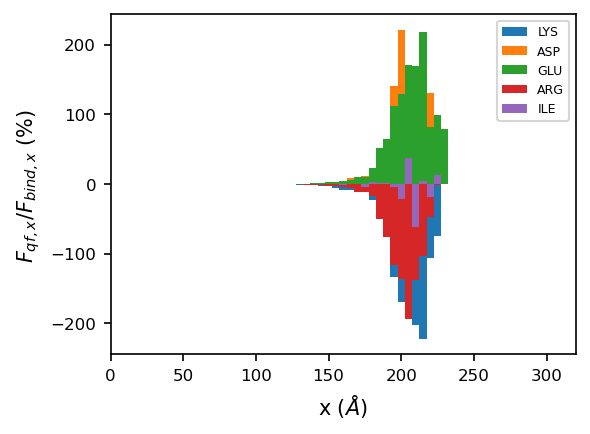

Max force in chain LYS: 221.84, slice location 215
Max force in chain ASP: 221.45, slice location 200
Max force in chain GLU: 217.99, slice location 215
Max force in chain ARG: 193.90, slice location 205
Max force in chain ILE: 61.51, slice location 210
Max force in chain THR: 57.95, slice location 225
Max force in chain SER: 53.57, slice location 210
Max force in chain ASN: 36.48, slice location 215
Max force in chain GLY: 36.47, slice location 210
Max force in chain ALA: 26.94, slice location 220
Max force in chain TYR: 23.54, slice location 215
Max force in chain TRP: 23.14, slice location 200
Max force in chain GLN: 20.52, slice location 215
Max force in chain VAL: 17.85, slice location 210
Max force in chain HIE: 16.81, slice location 195
Max force in chain PRO: 14.60, slice location 215
Max force in chain CYX: 13.99, slice location 215
Max force in chain LEU: 13.78, slice location 215
Max force in chain PHE: 12.11, slice location 215
Max force in chain MET: 11.58, slice location 

In [87]:
# identify amino acids names or chains
h= 5
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(0,235,h,fqf_386,types,position,amino_acid_name,case)


plt.clf()
plt.figure(figsize=(4,3),dpi=150)
# Minus sign in forces to follow the convention of the paper
plt.bar(planes, f_porcent_chain_mag[top_aa[0]],width=h,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[1]],width=h,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[3]],width=h,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[4]],width=h,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xlim([0,320]); plt.xticks(numpy.arange(0,350,50))
plt.savefig('plots\\forces_qf_condelta_bar_{0}_4a_{1}.pdf'.format(str(h),case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

# Verification of the most important amino acids by force magnitude
f_porcent_chain_mag_sorted = sorted(f_porcent_chain_mag.items(), key=lambda x: max(abs(x[1])), reverse=True)   
planes_fmax = []
aminoacid_fmax = []
for chain, forces in f_porcent_chain_mag_sorted:
    print('Max force in chain %s: %.2f, slice location %.1d' %(chain,max(abs(forces)),planes[numpy.argmax(abs(forces))]))
    planes_fmax.append(planes[numpy.argmax(abs(forces))])
    aminoacid_fmax.append(chain)


### Figure 4b)

<Figure size 432x288 with 0 Axes>

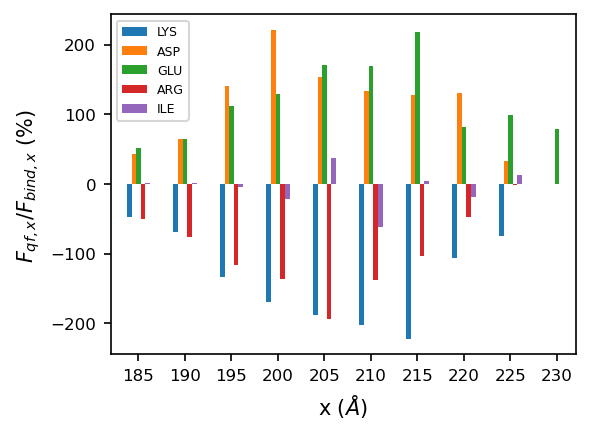

In [88]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4b_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c)

In [89]:
#count amino_acid_name in the file
n_aminoacid = dict()
for aminoacid in types:
    aminoacid_name = aminoacid.decode('utf-8')
    n_aminoacid[aminoacid_name] = len(numpy.where(aminoacid == amino_acid_name)[0])

# sort by number of atoms in n_aminoacid
n_aminoacid_sorted = sorted(n_aminoacid.items(), key=lambda x: x[1], reverse=True)   
print('Total number of atoms:', len(atom_name))
print('Total number of amino acids atoms:', sum(n_aminoacid.values()))
n_aminoacid_sorted

Total number of atoms: 1576628
Total number of amino acids atoms: 1576628


[('LEU', 188100),
 ('LYS', 126632),
 ('VAL', 118080),
 ('THR', 115920),
 ('ARG', 99360),
 ('ILE', 96120),
 ('SER', 87300),
 ('ALA', 85140),
 ('GLU', 78180),
 ('GLY', 71820),
 ('PHE', 68400),
 ('MET', 58140),
 ('HIE', 58140),
 ('TRP', 56160),
 ('ASP', 53952),
 ('TYR', 49140),
 ('GLN', 48960),
 ('PRO', 47880),
 ('ASN', 45360),
 ('CYX', 21600),
 ('CYS', 1980),
 ('GLH', 128),
 ('LYN', 84),
 ('ASH', 52)]

<Figure size 432x288 with 0 Axes>

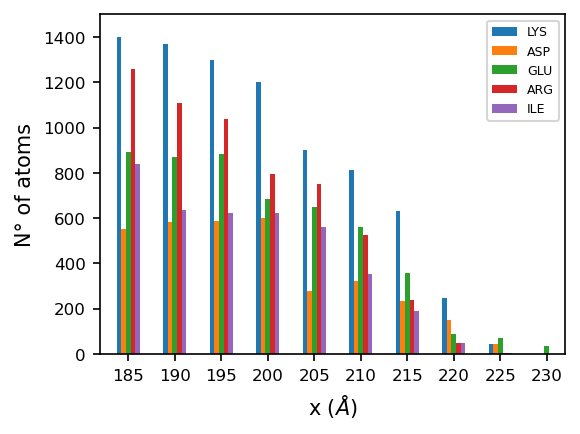

In [90]:
h= 5
planes, n_atoms = get_atoms_aminoacid_planes(0,235,h,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, n_atoms[top_aa[0]],width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2]) 
plt.bar(planes+h/10, n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'N° of atoms')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.ylim([0,1500])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4c) extra

<ipython-input-91-e4b6da190197>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes-2*h/10, (f_porcent_chain_mag[top_aa[0]] / n_atoms[top_aa[0]]) ,width=h/10,label=top_aa[0],color=top_aa_color[0])
<ipython-input-91-e4b6da190197>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1])
<ipython-input-91-e4b6da190197>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]]/n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3])
<ipython-input-91-e4b6da190197>:7: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]]/n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])


<Figure size 432x288 with 0 Axes>

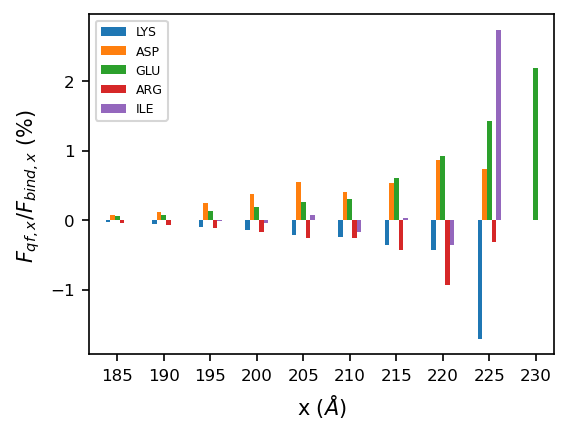

In [91]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, (f_porcent_chain_mag[top_aa[0]] / n_atoms[top_aa[0]]) ,width=h/10,label=top_aa[0],color=top_aa_color[0]) 
plt.bar(planes-h/10, f_porcent_chain_mag[top_aa[1]]/n_atoms[top_aa[1]],width=h/10,label=top_aa[1],color=top_aa_color[1]) 
plt.bar(planes, f_porcent_chain_mag[top_aa[2]]/n_atoms[top_aa[2]],width=h/10,label=top_aa[2],color=top_aa_color[2])
plt.bar(planes+h/10, f_porcent_chain_mag[top_aa[3]]/n_atoms[top_aa[3]],width=h/10,label=top_aa[3],color=top_aa_color[3]) 
plt.bar(planes+2*h/10, f_porcent_chain_mag[top_aa[4]]/n_atoms[top_aa[4]],width=h/10,label=top_aa[4],color=top_aa_color[4])
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf,x}/F_{bind,x}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots\\forces_qf_condelta_bar_{0}ang_4c_extra_{1}.pdf'.format(h,case), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Net charge calculation in slices

In [92]:
planes, qnet_chain = get_qnet_planes(-285,285,h,q,types,position,amino_acid_name)
qnet_chain_sorted = sorted(qnet_chain.items(), key=lambda x: max(x[1]), reverse=True)   
for chain, charge in qnet_chain_sorted:
    print('Max charge in chain %s: %.2f, slice location %.1d' %(chain,max(charge),planes[numpy.argmax(charge)]))

Max charge in chain LYS: 81.98, slice location -155
Max charge in chain ARG: 67.10, slice location -170
Max charge in chain GLY: 11.71, slice location -75
Max charge in chain ILE: 10.11, slice location 0
Max charge in chain ASN: 7.51, slice location -5
Max charge in chain THR: 7.45, slice location 100
Max charge in chain VAL: 7.28, slice location -135
Max charge in chain ALA: 7.23, slice location -55
Max charge in chain LEU: 7.03, slice location -115
Max charge in chain SER: 6.94, slice location -200
Max charge in chain HIE: 6.46, slice location -135
Max charge in chain PHE: 6.09, slice location -10
Max charge in chain PRO: 5.46, slice location -30
Max charge in chain GLN: 5.10, slice location 0
Max charge in chain TRP: 4.91, slice location 90
Max charge in chain MET: 4.16, slice location -150
Max charge in chain CYX: 3.58, slice location -95
Max charge in chain TYR: 3.43, slice location -140
Max charge in chain CYS: 1.56, slice location 0
Max charge in chain LYN: 0.68, slice location 

In [93]:
#Net charge per slices in max force location order
for j in range(len(planes_fmax)):
    index = numpy.where(planes == planes_fmax[j])[0][0]
    print('Max charge in chain %s: %.2f, slice location %.1d' %(aminoacid_fmax[j],qnet_chain[aminoacid_fmax[j]][index],planes[index]))

Max charge in chain LYS: 30.31, slice location 215
Max charge in chain ASP: -42.29, slice location 200
Max charge in chain GLU: -30.61, slice location 215
Max charge in chain ARG: 30.92, slice location 205
Max charge in chain ILE: 5.23, slice location 210
Max charge in chain THR: -1.78, slice location 225
Max charge in chain SER: -3.80, slice location 210
Max charge in chain ASN: 1.91, slice location 215
Max charge in chain GLY: 3.68, slice location 210
Max charge in chain ALA: 2.22, slice location 220
Max charge in chain TYR: -3.00, slice location 215
Max charge in chain TRP: -3.80, slice location 200
Max charge in chain GLN: 1.40, slice location 215
Max charge in chain VAL: 0.03, slice location 210
Max charge in chain HIE: 5.03, slice location 195
Max charge in chain PRO: 0.21, slice location 215
Max charge in chain CYX: 1.29, slice location 215
Max charge in chain LEU: 1.69, slice location 215
Max charge in chain PHE: 1.05, slice location 215
Max charge in chain MET: 0.97, slice loc